Required Files at Working Directory


1.   main.csv
2.   nasdaq_screener.csv



# Import Libraries

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import os
import math
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set Working Directory

In [ ]:
work_dir="/content/drive/MyDrive/StockPrediction"

# Load Data

In [ ]:
data = pd.read_csv(f"{work_dir}/main.csv")
cols_to_drop = data.columns[data.columns.str.contains('fiscal_quarter_key')]
data.drop(cols_to_drop, axis=1, inplace=True)
grouped = data.groupby('Symbol')

# Count the number of samples per symbol
lengths = [(symbol, len(group)) for symbol, group in grouped]
lengths_sorted = sorted(lengths, key=lambda x: x[1])

# Count the number of companies with more than or equal to 80 samples
count = sum(1 for symbol, length in lengths_sorted if length >= 80)
print("Number of companies with more than 80 samples:", count)
stockno = count
# Filter subgroups with more than or equal to 80 samples
filtered_groups = [(symbol, group) for symbol, group in grouped if len(group) >=80]

# Define a function to truncate each subgroup to 80 samples
def truncate_to_80(group):
    return group.iloc[:80]

# Apply the truncation function to each subgroup in filtered_groups
truncated_groups = [(symbol, truncate_to_80(group)) for symbol, group in filtered_groups]
filtered_data = pd.concat([group for symbol, group in truncated_groups])
companies = filtered_data['Symbol'].unique()
cols_to_drop = data.columns[data.columns.str.contains('Symbol')]
filtered_data.drop(cols_to_drop, axis=1, inplace=True)
cols_to_drop = data.columns[data.columns.str.contains('period_end_date')]
filtered_data.drop(cols_to_drop, axis=1, inplace=True)
cols_to_drop = data.columns[data.columns.str.contains('fiscal_quarter_number')]
filtered_data.drop(cols_to_drop, axis=1, inplace=True)
data = filtered_data.to_numpy()
print(len(data[0]))

Number of companies with more than 80 samples: 1658
109


# PreProcessing

In [ ]:
def pre_process(data,sequence_length,overlap,batch_size):
  # here 70 samples are grouped together into a sub group : Train and 10 : Test
  grouped_data = []
  grouped_data_test = []
  for i in range(stockno):
      train_start_index = i*80
      train_end_index = (i+1)*80-10

      test_start_index = train_end_index
      test_end_index = test_start_index + 10

      grouped_data.append(data[train_start_index:train_end_index])
      grouped_data_test.append(data[test_start_index:test_end_index])
  grouped_data = np.array(grouped_data) # contains data for each company in subgroup
  len(grouped_data[-1])
  grouped_data[0][0:0+sequence_length]

  # this cell normnalize the dataset by groupwise
  train_mean_ref=[]
  train_std_ref=[]

  test_mean_ref=[]
  test_std_ref=[]

  for i in range(len(grouped_data)):
      mean_vector = np.mean(grouped_data[i], axis=0)
      std_vector = np.std(grouped_data[i], axis=0)

      # Check for zero standard deviation
      zero_std_indices = np.where(std_vector == 0)[0]

      # Avoid division by zero and handle NaN
      std_vector[std_vector == 0] = 1  # Replace zero standard deviations with 1 to avoid division by zero

      # Reference of mean and std
      train_mean_ref.append(mean_vector)
      train_std_ref.append(std_vector)
      # Normalize the data
      normalized_data = (grouped_data[i] - mean_vector) / std_vector

      # Handle elements where standard deviation was zero
      normalized_data[:, zero_std_indices] = 0  # Set corresponding elements to zero

      # Assign the normalized data back to grouped_data
      grouped_data[i] = normalized_data


  for i in range(len(grouped_data_test)):
      mean_vector = np.mean(grouped_data_test[i], axis=0)
      std_vector = np.std(grouped_data_test[i], axis=0)

      # Check for zero standard deviation
      zero_std_indices = np.where(std_vector == 0)[0]

      # Avoid division by zero and handle NaN
      std_vector[std_vector == 0] = 1  # Replace zero standard deviations with 1 to avoid division by zero

      # Reference of mean and std
      test_mean_ref.append(mean_vector)
      test_std_ref.append(std_vector)
      # Normalize the data
      normalized_data = (grouped_data_test[i] - mean_vector) / std_vector

      # Handle elements where standard deviation was zero
      normalized_data[:, zero_std_indices] = 0  # Set corresponding elements to zero

      # Assign the normalized data back to grouped_data
      grouped_data_test[i] = normalized_data


# using sliding window mechanism to split train, test and validation data
  dataset=[]
  for i in range(len(grouped_data)):#1658
      for j in range(len(grouped_data[i])):#70
          if j*(sequence_length - overlap)+sequence_length < len(grouped_data[i]):
              datapoint = grouped_data[i][j*(sequence_length - overlap):j*(sequence_length - overlap)+sequence_length]
              #print(len(datapoint))
              dataset.append(datapoint)
          else:
              break
  dataset_test=[]
  for i in range(len(grouped_data_test)):#1658
      for j in range(len(grouped_data_test[i])):#70
          if j*(sequence_length - overlap)+sequence_length < len(grouped_data_test[i]):
              datapoint = grouped_data_test[i][j*(sequence_length - overlap):j*(sequence_length - overlap)+sequence_length]
              dataset_test.append(datapoint)
          else:
              break


  dataset = np.array(dataset)
  features = dataset[:, :, :-1]

  dataset_test = np.array(dataset_test)
  features_test = dataset_test[:, :, :-1]
  print(features.shape, features_test.shape)



  targets = []
  for i in range(len(grouped_data)):#1658
      for j in range(len(grouped_data[i])):#70
          if j*(sequence_length - overlap)+sequence_length < len(grouped_data[i]):
              target = grouped_data[i][j*(sequence_length - overlap)+sequence_length][-1]
              targets.append(target)
          else:
              break

  targets_test = []
  for i in range(len(grouped_data_test)):#1658
      for j in range(len(grouped_data_test[i])):#10
          if j*(sequence_length - overlap)+sequence_length < len(grouped_data_test[i]):
              target = grouped_data_test[i][j*(sequence_length - overlap)+sequence_length][-1]

              targets_test.append(target)
          else:
              #print(j)
              break

  targets = np.array(targets)
  print(targets.shape)
  features = torch.tensor(features, dtype=torch.float32)
  targets = torch.tensor(targets, dtype=torch.float32)


  targets_test = np.array(targets_test)
  print(targets_test.shape)
  features_test = torch.tensor(features_test, dtype=torch.float32)
  targets_test = torch.tensor(targets_test, dtype=torch.float32)



  X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)
  train_dataset = TensorDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataset = TensorDataset(X_val, y_val)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  test_dataset = TensorDataset(features_test, targets_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader,val_loader,test_loader,test_mean_ref,test_std_ref

# Model - CNN-BiLSTM-AT

In [ ]:
#Model Implementation

class CNN_BiLSTM_AM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, sequence_length, dropout_porb):
        super(CNN_BiLSTM_AM, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=1, padding=0, bias = True)
        self.conv1d_2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=1, padding=0, bias = True)
        self.conv1d_3 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=1, padding=0, bias = True)
        self.pool = nn.MaxPool1d(kernel_size=1, padding=0)
        self.lstm_1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=True, bias = True)
        self.lstm_2 = nn.LSTM(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True, bias = True)
        self.attention_linear = nn.Linear(hidden_dim * 2, 1, bias = True)
        self.linear = nn.Linear(hidden_dim * 2, output_dim, bias = True)
        self.sequence_length = sequence_length
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_dim)
        batch_size, sequence_length, input_dim = x.size()

        # Reshape for Conv1d input
        x = x.permute(0, 2, 1)  # Reshape for Conv1d input
        x = self.pool(F.relu(self.conv1d_1(x)))
        x = self.pool(F.relu(self.conv1d_2(x)))
        x = self.pool(F.relu(self.conv1d_3(x)))

        x = self.dropout(x)
        # Reshape for LSTM input
        x = x.permute(0, 2, 1)  # Reshape for LSTM input
        x, _ = self.lstm_1(x)
        x, _ = self.lstm_2(x)
        x = self.dropout(x)
        # Attention mechanism
        attention_weights = F.softmax(self.attention_linear(x), dim=1)
        attended_out = torch.sum(attention_weights * x, dim=1)

        # Output layer
        output = self.linear(attended_out)

        return output

# Model Run

In [ ]:
def model_run(model,train_loader,test_loader,val_loader,model_details,work_dir):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  train_losses = []
  val_losses = []
  num_epochs = 100
  all_predictions = []
  all_true_values = []

  # Training
  #best_val_loss = float('inf')
  patience = 10  # Number of epochs to wait for improvement
  counter = 0
  for epoch in range(num_epochs):
      model.train()
      running_train_loss = 0.0
      progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False, mininterval=1)
      for inputs, labels in progress_bar:
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs.float())
          loss = criterion(outputs.squeeze(), labels.float())

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          running_train_loss += loss.item()
          progress_bar.set_postfix({'loss': running_train_loss / len(train_loader)})

      # Record training loss for this epoch
      train_losses.append(running_train_loss / len(train_loader))

      # Validation loop
      model.eval()
      running_val_loss = 0.0
      predictions = []
      true_values = []
      with torch.no_grad():
      #    val_progress_bar = tqdm(val_dataloader, desc=f'Validation', leave=False, mininterval=1)
          for inputs, labels in val_loader:
              inputs, labels = inputs.to(device), labels.to(device)#labels are normalized

              # Forward pass
              normalized_outputs = model(inputs.float())
              loss = criterion(normalized_outputs.squeeze(), labels.float()) # losses are computed between normalized outputs and nromalized prediction

              running_val_loss += loss.item()

              #outputs = normalized_outputs * vector_max[-1]
              #labels = labels * vector_max[-1]
              # Store predicted and true values
              predictions.extend(normalized_outputs.cpu().numpy())
              true_values.extend(labels.cpu().numpy())

          # Record validation loss for this epoch
          val_losses.append(running_val_loss / len(val_loader))

      all_predictions.append(predictions)
      all_true_values.append(true_values)

      #TestingModel
      model.eval()
      running_test_loss = 0.0
      predictions_test_data = []
      true_values_test_data = []
      with torch.no_grad():
      #    val_progress_bar = tqdm(val_dataloader, desc=f'Validation', leave=False, mininterval=1)
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)#labels are normalized

              # Forward pass
              normalized_outputs = model(inputs.float())
              loss = criterion(normalized_outputs.squeeze(), labels.float()) # losses are computed between normalized outputs and nromalized prediction

              running_val_loss += loss.item()

              #outputs = normalized_outputs * vector_max[-1]
              #labels = labels * vector_max[-1]
              # Store predicted and true values
              predictions_test_data.extend(normalized_outputs.cpu().numpy())
              true_values_test_data.extend(labels.cpu().numpy())

          print(f"Test Loss for {model_details}:", running_val_loss / len(test_loader))
      """
      avg_val_loss = running_val_loss / len(val_dataloader)
      if avg_val_loss < best_val_loss: #check for the improvement of val_loss
          best_val_loss = avg_val_loss
          counter = 0
      else:
          counter = counter + 1
      if counter >= patience:
          print(f'Early stopping after {epoch+1} epochs without improvement.')
          break"""
      # Print average loss for this epoch
      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

  # Plot training and validation losses
  plt.figure()
  plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
  plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Training and Validation Losses for {model_details}')
  plt.legend()
  plt.show()
  plt.savefig(f'{work_dir}/model_loss_{model_details}.png')

  #TestingModel
  model.eval()
  running_test_loss = 0.0
  predictions_test_data = []
  true_values_test_data = []
  with torch.no_grad():
  #    val_progress_bar = tqdm(val_dataloader, desc=f'Validation', leave=False, mininterval=1)
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)#labels are normalized

          # Forward pass
          normalized_outputs = model(inputs.float())
          loss = criterion(normalized_outputs.squeeze(), labels.float()) # losses are computed between normalized outputs and nromalized prediction

          running_val_loss += loss.item()

          #outputs = normalized_outputs * vector_max[-1]
          #labels = labels * vector_max[-1]
          # Store predicted and true values
          predictions_test_data.extend(normalized_outputs.cpu().numpy())
          true_values_test_data.extend(labels.cpu().numpy())

      print(f"Test Loss for {model_details}:", running_val_loss / len(test_loader))


  torch.save(model.state_dict(), f"{work_dir}/model.state")
  return predictions_test_data,true_values_test_data

# PostProcessing

In [ ]:
def post_processing(test_mean_ref,test_std_ref,predictions_test_data,true_values_test_data,sequence_length,model_details,work_dir, companies):
  test_mean_ref_target = []
  test_std_ref_target = []

  for i in range(len(test_mean_ref)):
    test_mean_ref_target.append(test_mean_ref[i][-1])
    test_std_ref_target.append(test_std_ref[i][-1])

  test_by_comp_pred=[]
  test_by_comp_act=[]
  test_by_comp_pred = [x[0] for x in predictions_test_data]

  test_by_comp_pred = [test_by_comp_pred[i * (10-sequence_length) : (i + 1) * (10-sequence_length)] for i in range(stockno)]
  test_by_comp_act = [true_values_test_data[i * (10-sequence_length) : (i + 1) * (10-sequence_length)] for i in range(stockno)]

  for i in range(len(test_by_comp_pred)):
    test_by_comp_pred[i] = [x * test_std_ref_target[i] + test_mean_ref_target[i] for x in test_by_comp_pred[i]]
    test_by_comp_act[i] = [x * test_std_ref_target[i] + test_mean_ref_target[i] for x in test_by_comp_act[i]]


  pct_value_error = {}
  maerr = {}
  for i in range(len(test_by_comp_act)):
    pred_tmp = test_by_comp_pred[i]
    act_tmp = test_by_comp_act[i]
    pct_value_error[companies[i]] = mean_absolute_percentage_error(act_tmp,pred_tmp)
    maerr[companies[i]] = mean_absolute_error(act_tmp,pred_tmp)


  with open(f'{work_dir}/mae_{model_details}.json', 'w') as convert_file:
     convert_file.write(json.dumps(maerr))

  with open(f'{work_dir}/pct_{model_details}.json', 'w') as convert_file:
     convert_file.write(json.dumps(pct_value_error))

  predictions={}
  actual={}

  for i in range(len(test_by_comp_pred)):
    predictions[companies[i]]=test_by_comp_pred[i]
    actual[companies[i]]=test_by_comp_act[i]

  with open(f'{work_dir}/pred_{model_details}.json', 'w') as convert_file:
     convert_file.write(json.dumps(predictions))

  with open(f'{work_dir}/act_{model_details}.json', 'w') as convert_file:
      convert_file.write(json.dumps(actual))


# Experiment Setup

cuda
Model: CNN_LSTM_AM
(109428, 4, 108) (9948, 4, 108)
(109428,)
(9948,)


Test Loss for CNN_LSTM_AM: 1.3990557865057158
Epoch 1/100, Train Loss: 0.3176170760177412, Val Loss: 0.22653047497209894


Test Loss for CNN_LSTM_AM: 1.3424828293260618
Epoch 2/100, Train Loss: 0.21822670217962997, Val Loss: 0.20382211957824284


Test Loss for CNN_LSTM_AM: 1.3000540505701572
Epoch 3/100, Train Loss: 0.20469289904152885, Val Loss: 0.19801880813896927


Test Loss for CNN_LSTM_AM: 1.2972331180157672
Epoch 4/100, Train Loss: 0.19796887100347105, Val Loss: 0.19337003524138774


Test Loss for CNN_LSTM_AM: 1.3039829545378236
Epoch 5/100, Train Loss: 0.19409723555204325, Val Loss: 0.192467735174482


Test Loss for CNN_LSTM_AM: 1.2771108251242855
Epoch 6/100, Train Loss: 0.19113743561679025, Val Loss: 0.19135669202301397


Test Loss for CNN_LSTM_AM: 1.2752396809311592
Epoch 7/100, Train Loss: 0.1891272413543825, Val Loss: 0.18983034632002857


Test Loss for CNN_LSTM_AM: 1.2054354584069182
Epoch 8/100, Train Loss: 0.18622499793504116, Val Loss: 0.18971294625853635


Test Loss for CNN_LSTM_AM: 1.2300879440303125
Epoch 9/100, Train Loss: 0.18471288906973066, Val Loss: 0.18824498676035775


Test Loss for CNN_LSTM_AM: 1.263737245121194
Epoch 10/100, Train Loss: 0.182827069903317, Val Loss: 0.1880960270558318


Test Loss for CNN_LSTM_AM: 1.226907223701739
Epoch 11/100, Train Loss: 0.18173796542548387, Val Loss: 0.1868163369081438


Test Loss for CNN_LSTM_AM: 1.2449657408118098
Epoch 12/100, Train Loss: 0.1809826229556944, Val Loss: 0.18607869844237282


Test Loss for CNN_LSTM_AM: 1.210949478413554
Epoch 13/100, Train Loss: 0.17973206689669566, Val Loss: 0.18556220328316228


Test Loss for CNN_LSTM_AM: 1.237860871006234
Epoch 14/100, Train Loss: 0.1787492045691223, Val Loss: 0.18667886623279212


Test Loss for CNN_LSTM_AM: 1.267475607458633
Epoch 15/100, Train Loss: 0.17762767700483753, Val Loss: 0.18790315076938435


Test Loss for CNN_LSTM_AM: 1.259563132900576
Epoch 16/100, Train Loss: 0.1772550995504725, Val Loss: 0.18472438421500123


Test Loss for CNN_LSTM_AM: 1.2366240385489249
Epoch 17/100, Train Loss: 0.17629395095234698, Val Loss: 0.18502697494884604


Test Loss for CNN_LSTM_AM: 1.2249577294744962
Epoch 18/100, Train Loss: 0.17563068244270108, Val Loss: 0.18806941878501343


Test Loss for CNN_LSTM_AM: 1.2843681701538552
Epoch 19/100, Train Loss: 0.17463457805111468, Val Loss: 0.1873379214135207


Test Loss for CNN_LSTM_AM: 1.2352853862091375
Epoch 20/100, Train Loss: 0.1744580728489627, Val Loss: 0.18417978160440512


Test Loss for CNN_LSTM_AM: 1.2545146451720117
Epoch 21/100, Train Loss: 0.17360558294649128, Val Loss: 0.183534332370326


Test Loss for CNN_LSTM_AM: 1.2425587693107638
Epoch 22/100, Train Loss: 0.17261030388382215, Val Loss: 0.1848526613990942


Test Loss for CNN_LSTM_AM: 1.2552317526640755
Epoch 23/100, Train Loss: 0.17211269818699526, Val Loss: 0.18382876946858756


Test Loss for CNN_LSTM_AM: 1.2543610459493109
Epoch 24/100, Train Loss: 0.17181135118348062, Val Loss: 0.18294130745620285


Test Loss for CNN_LSTM_AM: 1.221752473228054
Epoch 25/100, Train Loss: 0.17148468068464187, Val Loss: 0.18277093243985076


Test Loss for CNN_LSTM_AM: 1.2079772472887034
Epoch 26/100, Train Loss: 0.17052472354647416, Val Loss: 0.1837932658955863


Test Loss for CNN_LSTM_AM: 1.2715890789685311
Epoch 27/100, Train Loss: 0.16999301281802862, Val Loss: 0.18485329433909903


Test Loss for CNN_LSTM_AM: 1.24357449893264
Epoch 28/100, Train Loss: 0.16939822930538403, Val Loss: 0.18261241380839724


Test Loss for CNN_LSTM_AM: 1.266565547666358
Epoch 29/100, Train Loss: 0.1692269164090205, Val Loss: 0.18273741864178278


Test Loss for CNN_LSTM_AM: 1.2269588093175061
Epoch 30/100, Train Loss: 0.1680851126651358, Val Loss: 0.18298325972572038


Test Loss for CNN_LSTM_AM: 1.2336271625976243
Epoch 31/100, Train Loss: 0.16873973521533214, Val Loss: 0.18324889602632896


Test Loss for CNN_LSTM_AM: 1.2283994901607085
Epoch 32/100, Train Loss: 0.16785779242738358, Val Loss: 0.18152906967658702


Test Loss for CNN_LSTM_AM: 1.222036665197855
Epoch 33/100, Train Loss: 0.1669964076773498, Val Loss: 0.18300089458445912


Test Loss for CNN_LSTM_AM: 1.2456706206234704
Epoch 34/100, Train Loss: 0.16656118588759294, Val Loss: 0.18201048081511095


Test Loss for CNN_LSTM_AM: 1.2440589766378454
Epoch 35/100, Train Loss: 0.16611320326910028, Val Loss: 0.18228565223013224


Test Loss for CNN_LSTM_AM: 1.2439750282973725
Epoch 36/100, Train Loss: 0.16570190177950636, Val Loss: 0.18195740020191764


Test Loss for CNN_LSTM_AM: 1.2068723785929645
Epoch 37/100, Train Loss: 0.16500717486977695, Val Loss: 0.18396866701747458


Test Loss for CNN_LSTM_AM: 1.2198064972332974
Epoch 38/100, Train Loss: 0.16455329409659522, Val Loss: 0.180997754868171


Test Loss for CNN_LSTM_AM: 1.2355318513918836
Epoch 39/100, Train Loss: 0.16425464597973718, Val Loss: 0.18219782607885052


Test Loss for CNN_LSTM_AM: 1.197154889987716
Epoch 40/100, Train Loss: 0.1636983674282324, Val Loss: 0.1829522380384204


Test Loss for CNN_LSTM_AM: 1.237945325836427
Epoch 41/100, Train Loss: 0.16327974075575954, Val Loss: 0.18161364653908976


Test Loss for CNN_LSTM_AM: 1.1972644137611717
Epoch 42/100, Train Loss: 0.16347598154597764, Val Loss: 0.18223554893826308


Test Loss for CNN_LSTM_AM: 1.2456252289627066
Epoch 43/100, Train Loss: 0.1631602978834862, Val Loss: 0.1822435394541858


Test Loss for CNN_LSTM_AM: 1.2273498651988093
Epoch 44/100, Train Loss: 0.1619835146934194, Val Loss: 0.18220833939453374


Test Loss for CNN_LSTM_AM: 1.211653973439231
Epoch 45/100, Train Loss: 0.16134055288107496, Val Loss: 0.18208001744529428


Test Loss for CNN_LSTM_AM: 1.2201809460512507
Epoch 46/100, Train Loss: 0.16114413096856162, Val Loss: 0.18354797419841024


Test Loss for CNN_LSTM_AM: 1.2305874323809343
Epoch 47/100, Train Loss: 0.1604359289859956, Val Loss: 0.18342629113536515


Test Loss for CNN_LSTM_AM: 1.2182578587782893
Epoch 48/100, Train Loss: 0.16010140820003743, Val Loss: 0.18211819998256557


Test Loss for CNN_LSTM_AM: 1.1958028722844607
Epoch 49/100, Train Loss: 0.1599201259710137, Val Loss: 0.1833778175814545


Test Loss for CNN_LSTM_AM: 1.2073919157867306
Epoch 50/100, Train Loss: 0.1597905236816003, Val Loss: 0.18365387800128358


Test Loss for CNN_LSTM_AM: 1.216356517176083
Epoch 51/100, Train Loss: 0.15962513226660438, Val Loss: 0.18242742247947547


Test Loss for CNN_LSTM_AM: 1.198766345017819
Epoch 52/100, Train Loss: 0.15863655539690122, Val Loss: 0.18306669887138283


Test Loss for CNN_LSTM_AM: 1.2051720266609485
Epoch 53/100, Train Loss: 0.15875279825863703, Val Loss: 0.18292201525153226


Test Loss for CNN_LSTM_AM: 1.230687580553431
Epoch 54/100, Train Loss: 0.1577834247349246, Val Loss: 0.18127975250556044


Test Loss for CNN_LSTM_AM: 1.186861255697569
Epoch 55/100, Train Loss: 0.15783819406724686, Val Loss: 0.18467109669084963


Test Loss for CNN_LSTM_AM: 1.1898218837505834
Epoch 56/100, Train Loss: 0.15781874220599146, Val Loss: 0.18294636436342582


Test Loss for CNN_LSTM_AM: 1.2009897304970265
Epoch 57/100, Train Loss: 0.15728804426717713, Val Loss: 0.18280112605167714


Test Loss for CNN_LSTM_AM: 1.1972307845173245
Epoch 58/100, Train Loss: 0.15715115224790446, Val Loss: 0.18377846037356615


Test Loss for CNN_LSTM_AM: 1.1903747308475139
Epoch 59/100, Train Loss: 0.1567333393779688, Val Loss: 0.1832790087406698


Test Loss for CNN_LSTM_AM: 1.2011070628673886
Epoch 60/100, Train Loss: 0.15659898404097944, Val Loss: 0.18422701709040495


Test Loss for CNN_LSTM_AM: 1.1707998222283007
Epoch 61/100, Train Loss: 0.15596903924022332, Val Loss: 0.18412781697931832


Test Loss for CNN_LSTM_AM: 1.158720612909701
Epoch 62/100, Train Loss: 0.15627757449241314, Val Loss: 0.1858173002059397


Test Loss for CNN_LSTM_AM: 1.2063703757088313
Epoch 63/100, Train Loss: 0.15504210434539156, Val Loss: 0.18361800003873363


Test Loss for CNN_LSTM_AM: 1.1949341108685536
Epoch 64/100, Train Loss: 0.15577106522039846, Val Loss: 0.18222031008545733


Test Loss for CNN_LSTM_AM: 1.182670439635614
Epoch 65/100, Train Loss: 0.1548415223186541, Val Loss: 0.18370542567665582


Test Loss for CNN_LSTM_AM: 1.1756163673971467
Epoch 66/100, Train Loss: 0.15462207017431323, Val Loss: 0.18747828833622748


Test Loss for CNN_LSTM_AM: 1.174796300369254
Epoch 67/100, Train Loss: 0.15432085092155542, Val Loss: 0.18628460171177438


Test Loss for CNN_LSTM_AM: 1.1917405864317439
Epoch 68/100, Train Loss: 0.15409994380615613, Val Loss: 0.1858493722698834


Test Loss for CNN_LSTM_AM: 1.185977838591827
Epoch 69/100, Train Loss: 0.15442729459651058, Val Loss: 0.1850975185067108


Test Loss for CNN_LSTM_AM: 1.1905755917986285
Epoch 70/100, Train Loss: 0.15390244624159938, Val Loss: 0.18471553584467196


Test Loss for CNN_LSTM_AM: 1.18046263167775
Epoch 71/100, Train Loss: 0.153133169116547, Val Loss: 0.1843664048082242


Test Loss for CNN_LSTM_AM: 1.1795191772787565
Epoch 72/100, Train Loss: 0.15307449528746422, Val Loss: 0.18315809399110677


Test Loss for CNN_LSTM_AM: 1.2093427141229787
Epoch 73/100, Train Loss: 0.15340791676759397, Val Loss: 0.18276743463465953


Test Loss for CNN_LSTM_AM: 1.1804248754112938
Epoch 74/100, Train Loss: 0.15304230228289833, Val Loss: 0.18308674206651032


Test Loss for CNN_LSTM_AM: 1.173817523703653
Epoch 75/100, Train Loss: 0.15271255336084888, Val Loss: 0.18534668505225824


Test Loss for CNN_LSTM_AM: 1.1899174773859693
Epoch 76/100, Train Loss: 0.1525196798229808, Val Loss: 0.18230664413890132


Test Loss for CNN_LSTM_AM: 1.2266614864341652
Epoch 77/100, Train Loss: 0.15180510261507205, Val Loss: 0.1833688384581136


Test Loss for CNN_LSTM_AM: 1.1804962800956103
Epoch 78/100, Train Loss: 0.1517984597246428, Val Loss: 0.18516030589110094


Test Loss for CNN_LSTM_AM: 1.196150495366535
Epoch 79/100, Train Loss: 0.15173485125231528, Val Loss: 0.1836030591602467


Test Loss for CNN_LSTM_AM: 1.1838722900398562
Epoch 80/100, Train Loss: 0.1512656409542333, Val Loss: 0.18205835151839067


Test Loss for CNN_LSTM_AM: 1.1604316681108657
Epoch 81/100, Train Loss: 0.15155254357650255, Val Loss: 0.1862900423238981


Test Loss for CNN_LSTM_AM: 1.1775208961349637
Epoch 82/100, Train Loss: 0.1514659979514169, Val Loss: 0.18632690787111242


Test Loss for CNN_LSTM_AM: 1.1916872839298305
Epoch 83/100, Train Loss: 0.15052363577366368, Val Loss: 0.18386088820922797


Test Loss for CNN_LSTM_AM: 1.1945923920393215
Epoch 84/100, Train Loss: 0.15107555201448403, Val Loss: 0.1824527109726481


Test Loss for CNN_LSTM_AM: 1.1699983954813387
Epoch 85/100, Train Loss: 0.15063052786687556, Val Loss: 0.18571834151577798


Test Loss for CNN_LSTM_AM: 1.168903588069294
Epoch 86/100, Train Loss: 0.1497119020645122, Val Loss: 0.18531838744096288


Test Loss for CNN_LSTM_AM: 1.1846182009851063
Epoch 87/100, Train Loss: 0.150170041979006, Val Loss: 0.18211440359705797


Test Loss for CNN_LSTM_AM: 1.190918959499379
Epoch 88/100, Train Loss: 0.14982751592715032, Val Loss: 0.18264337833630576


Test Loss for CNN_LSTM_AM: 1.1456812444100877
Epoch 89/100, Train Loss: 0.14947289456881963, Val Loss: 0.18999199306838996


Test Loss for CNN_LSTM_AM: 1.1847490767419488
Epoch 90/100, Train Loss: 0.14918864161990952, Val Loss: 0.1840662652898801


Test Loss for CNN_LSTM_AM: 1.166484845465227
Epoch 91/100, Train Loss: 0.14899064487815414, Val Loss: 0.1848420021613235


Test Loss for CNN_LSTM_AM: 1.1686928022053822
Epoch 92/100, Train Loss: 0.1491393180625744, Val Loss: 0.18812440090374724


Test Loss for CNN_LSTM_AM: 1.1851430783357153
Epoch 93/100, Train Loss: 0.14871774825226539, Val Loss: 0.18622529004024316


Test Loss for CNN_LSTM_AM: 1.199015114007134
Epoch 94/100, Train Loss: 0.14864281118650102, Val Loss: 0.18602211939247504


Test Loss for CNN_LSTM_AM: 1.2044077740663934
Epoch 95/100, Train Loss: 0.14866460079985694, Val Loss: 0.18306322445344503


Test Loss for CNN_LSTM_AM: 1.2021152063286933
Epoch 96/100, Train Loss: 0.14781653278878013, Val Loss: 0.1845323540329865


Test Loss for CNN_LSTM_AM: 1.20160305673659
Epoch 97/100, Train Loss: 0.14802474395049123, Val Loss: 0.18399058231981855


Test Loss for CNN_LSTM_AM: 1.1869574504338167
Epoch 98/100, Train Loss: 0.14796174577687857, Val Loss: 0.1839307353334272


Test Loss for CNN_LSTM_AM: 1.2032095561805531
Epoch 99/100, Train Loss: 0.14805552127028043, Val Loss: 0.18304356780821737


Test Loss for CNN_LSTM_AM: 1.1987253909827627
Epoch 100/100, Train Loss: 0.148280148593861, Val Loss: 0.18333085752666406


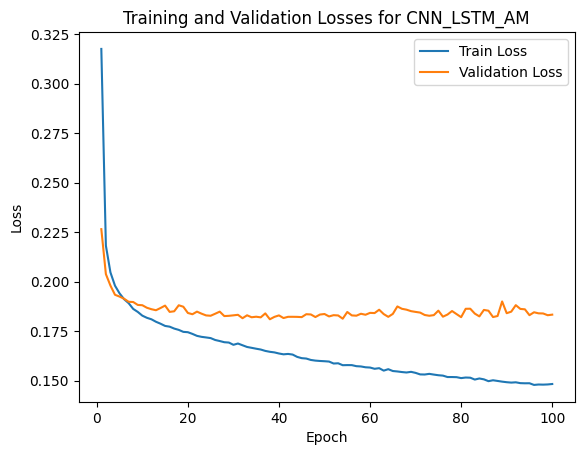

Test Loss for CNN_LSTM_AM: 1.9939386432887471


<Figure size 640x480 with 0 Axes>

In [ ]:
sequence_length = 4
overlap = 3
batch_size = 25
input_dim = len(data[0]) - 1
hidden_dim = 32
output_dim = 1
dropout_prob = 0.2


#initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#MLP_model = MLP(input_dim, output_dim, sequence_length).to(device)
# LSTM_model = LSTM(input_dim, 2, output_dim).to(device)
# LSTM_AT_model = LSTMAttentionRegressor(input_dim, 2, output_dim).to(device)
CNN_BiLSTM_AM_model = CNN_BiLSTM_AM(input_dim, hidden_dim, output_dim, sequence_length, dropout_prob).to(device)

models={
        'CNN_LSTM_AM':CNN_BiLSTM_AM_model}

# Model implementation
for model_name,model in models.items():
  print("Model:",model_name)
  train_loader,val_loader,test_loader,test_mean_ref,test_std_ref = pre_process(data,sequence_length,overlap,batch_size)
  predictions_test_data,true_values_test_data = model_run(model,train_loader,test_loader,val_loader,model_name,work_dir)
  post_processing(test_mean_ref,test_std_ref,predictions_test_data,true_values_test_data,sequence_length,model_name,work_dir, companies)